In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
import glob
import yahist
from matplotlib.collections import LineCollection

from utils import load_df_nytimes

In [2]:
yahist.utils.set_default_style()

In [3]:
avg_over = 7
df_counties = load_df_nytimes(counties=True, cases=True, avg_over=avg_over)
df_states = load_df_nytimes(counties=False, cases=True, avg_over=avg_over)

In [4]:
df_states

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,
2020-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-14,52139.714286,1677.142857,118993.285714,27572.000000,320261.428571,36518.428571,47316.857143,12720.000000,10794.857143,256997.428571,...,59946.428571,257221.428571,28954.857143,1284.285714,175.571429,69833.000000,41774.571429,4089.428571,39059.000000,1837.000000
2020-07-15,53869.000000,1746.571429,122236.285714,28293.571429,328717.571429,36954.857143,47392.285714,12804.000000,10849.714286,268144.142857,...,61769.142857,266844.571429,29570.142857,1293.142857,190.571429,70711.857143,42537.857143,4210.857143,39899.428571,1872.000000
2020-07-16,55571.000000,1819.857143,125371.571429,29016.714286,337466.857143,37413.857143,47469.571429,12887.285714,10906.428571,280009.428571,...,63668.571429,277057.571429,30181.000000,1300.714286,207.571429,71632.285714,43380.571429,4329.571429,40757.000000,1908.000000


In [5]:
max_date = str(df_states.index.max()).split()[0]
max_date

'2020-07-18'

In [6]:
def plot(max_date="2020-04-17", regions="states", frac=1.0, alpha_lines=0.25, alpha_markers=0.6, fname=None):
     # frac = 1.0 means take the latest point, 0.0 means take the previous point
    if regions == "states":
        dfcurr = df_states
    if regions == "counties":
        dfcurr = df_counties
        alpha_lines=0.01
        alpha_markers = 0.1
    dfdiff = dfcurr.diff()
    
    prev_date = str(pd.Timestamp(max_date)-pd.Timedelta("1 day")).split()[0]

    lines = []
    for place in dfcurr.columns:
        cases = dfcurr[place].loc[:max_date]
        newcases = dfdiff[place].loc[:max_date]
        line = np.array(np.c_[cases,newcases][1:,:])
        line[-1] = frac*line[-1] + (1-frac)*line[-2]
        lines.append(line)

    lc = LineCollection(lines, color="gray", lw=1, alpha=alpha_lines)

    fig, ax = plt.subplots()
    ax.add_collection(lc)
    xs = frac*dfcurr.loc[max_date] + (1-frac)*dfcurr.loc[prev_date]
    ys = frac*dfdiff.loc[max_date] + (1-frac)*dfdiff.loc[prev_date]
    d_highlight = {
        "Arizona": ["AZ",[1.,0.,0]],
        "Florida": ["FL",[1.,0.,0]],
        "California": ["CA",[1.,0.,0]],
        "Texas": ["TX",[1.,0.,0]],
        "New York": ["NY",[0.,0.,1]],
    }
    def f(s):
        pair = d_highlight.get(s)
        if not pair: color = [0,0,0]
        else: color = pair[1]
        return color
    colors = np.vstack(ys.index.map(f))
    ax.scatter(xs,ys,s = 8.0,color=colors,alpha=alpha_markers)
    xmin = 1
    ymin = 1
    for k,v in d_highlight.items():
        if xs[k] < xmin: continue
        if ys[k] < ymin: continue
        ax.text(xs[k], 1.2*ys[k], v[0], ha='center', va='bottom', transform=ax.transData, color=v[1], fontsize=8)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([xmin,1e6])
    ax.set_ylim([ymin,1e6])
    ax.set_xlabel("current cumulative cases")
    ax.set_ylabel(f"new cases ({avg_over} day avg)")
    ax.set_title(f"cases in {regions} up to {max_date}")
    ax.grid(alpha=0.25)
    
    if fname:
        fig.savefig(fname)
        plt.close()


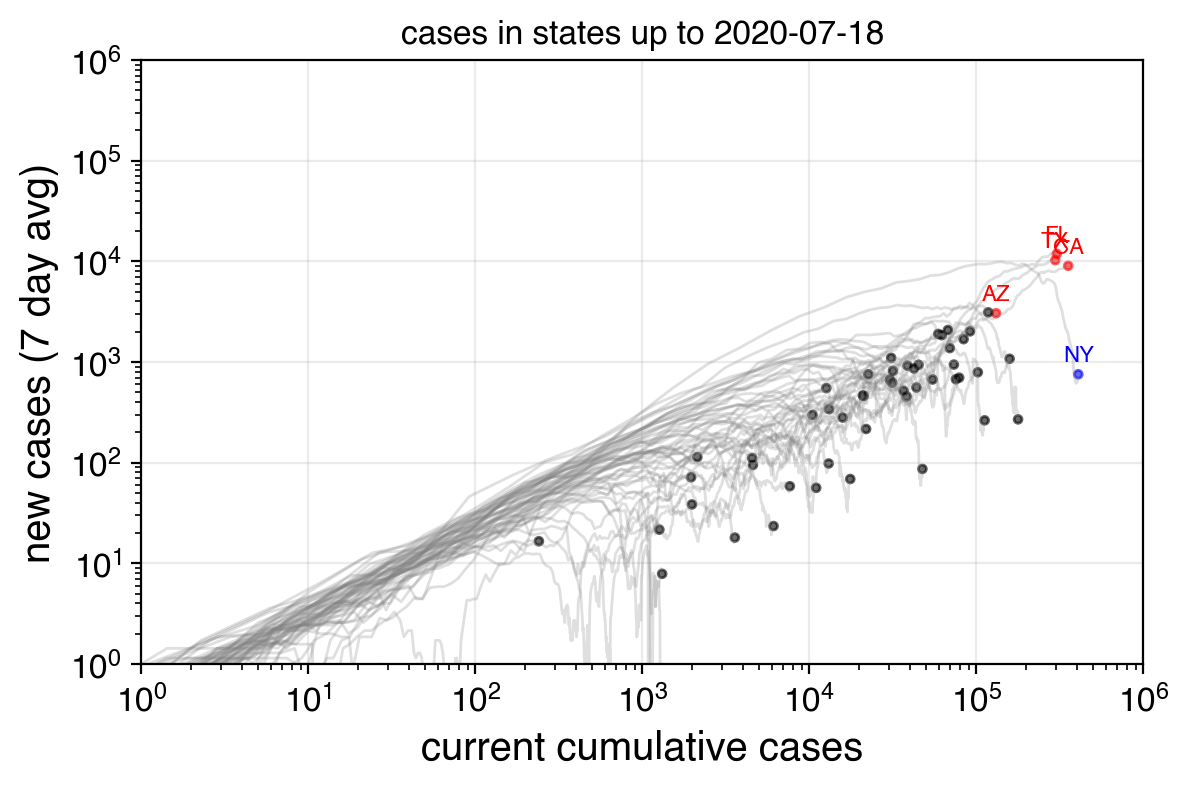

In [7]:
plot(max_date=max_date, regions="states", frac=1.0)
# plot(max_date=f"2020-05-03", regions="counties", frac=1.0)

In [8]:
!mkdir -p plot_trajectories/
!rm plot_trajectories/*.png

regions = "states"
# regions = "counties"

dates = pd.date_range("2020-02-12",max_date,freq="D").strftime("%Y-%m-%d")
for date in dates:
#     for frac in np.linspace(0,0.9,10):
    for frac in np.linspace(0,0.9,4):
        # frac 0 does the previous day, so we start with 0.0 to 0.9, then 
        # when i increments, it's the next day
        ifrac = int(frac*10)
        fname = f"plot_trajectories/plot_{date}_{ifrac}.png"
        print(fname)
        plot(max_date=date, frac=frac, regions=regions, fname=fname)


plot_trajectories/plot_2020-02-12_0.png
plot_trajectories/plot_2020-02-12_3.png
plot_trajectories/plot_2020-02-12_6.png
plot_trajectories/plot_2020-02-12_9.png
plot_trajectories/plot_2020-02-13_0.png
plot_trajectories/plot_2020-02-13_3.png
plot_trajectories/plot_2020-02-13_6.png
plot_trajectories/plot_2020-02-13_9.png
plot_trajectories/plot_2020-02-14_0.png
plot_trajectories/plot_2020-02-14_3.png
plot_trajectories/plot_2020-02-14_6.png
plot_trajectories/plot_2020-02-14_9.png
plot_trajectories/plot_2020-02-15_0.png
plot_trajectories/plot_2020-02-15_3.png
plot_trajectories/plot_2020-02-15_6.png
plot_trajectories/plot_2020-02-15_9.png
plot_trajectories/plot_2020-02-16_0.png
plot_trajectories/plot_2020-02-16_3.png
plot_trajectories/plot_2020-02-16_6.png
plot_trajectories/plot_2020-02-16_9.png
plot_trajectories/plot_2020-02-17_0.png
plot_trajectories/plot_2020-02-17_3.png
plot_trajectories/plot_2020-02-17_6.png
plot_trajectories/plot_2020-02-17_9.png
plot_trajectories/plot_2020-02-18_0.png


plot_trajectories/plot_2020-04-03_3.png
plot_trajectories/plot_2020-04-03_6.png
plot_trajectories/plot_2020-04-03_9.png
plot_trajectories/plot_2020-04-04_0.png
plot_trajectories/plot_2020-04-04_3.png
plot_trajectories/plot_2020-04-04_6.png
plot_trajectories/plot_2020-04-04_9.png
plot_trajectories/plot_2020-04-05_0.png
plot_trajectories/plot_2020-04-05_3.png
plot_trajectories/plot_2020-04-05_6.png
plot_trajectories/plot_2020-04-05_9.png
plot_trajectories/plot_2020-04-06_0.png
plot_trajectories/plot_2020-04-06_3.png
plot_trajectories/plot_2020-04-06_6.png
plot_trajectories/plot_2020-04-06_9.png
plot_trajectories/plot_2020-04-07_0.png
plot_trajectories/plot_2020-04-07_3.png
plot_trajectories/plot_2020-04-07_6.png
plot_trajectories/plot_2020-04-07_9.png
plot_trajectories/plot_2020-04-08_0.png
plot_trajectories/plot_2020-04-08_3.png
plot_trajectories/plot_2020-04-08_6.png
plot_trajectories/plot_2020-04-08_9.png
plot_trajectories/plot_2020-04-09_0.png
plot_trajectories/plot_2020-04-09_3.png


plot_trajectories/plot_2020-05-24_6.png
plot_trajectories/plot_2020-05-24_9.png
plot_trajectories/plot_2020-05-25_0.png
plot_trajectories/plot_2020-05-25_3.png
plot_trajectories/plot_2020-05-25_6.png
plot_trajectories/plot_2020-05-25_9.png
plot_trajectories/plot_2020-05-26_0.png
plot_trajectories/plot_2020-05-26_3.png
plot_trajectories/plot_2020-05-26_6.png
plot_trajectories/plot_2020-05-26_9.png
plot_trajectories/plot_2020-05-27_0.png
plot_trajectories/plot_2020-05-27_3.png
plot_trajectories/plot_2020-05-27_6.png
plot_trajectories/plot_2020-05-27_9.png
plot_trajectories/plot_2020-05-28_0.png
plot_trajectories/plot_2020-05-28_3.png
plot_trajectories/plot_2020-05-28_6.png
plot_trajectories/plot_2020-05-28_9.png
plot_trajectories/plot_2020-05-29_0.png
plot_trajectories/plot_2020-05-29_3.png
plot_trajectories/plot_2020-05-29_6.png
plot_trajectories/plot_2020-05-29_9.png
plot_trajectories/plot_2020-05-30_0.png
plot_trajectories/plot_2020-05-30_3.png
plot_trajectories/plot_2020-05-30_6.png


plot_trajectories/plot_2020-07-14_9.png
plot_trajectories/plot_2020-07-15_0.png
plot_trajectories/plot_2020-07-15_3.png
plot_trajectories/plot_2020-07-15_6.png
plot_trajectories/plot_2020-07-15_9.png
plot_trajectories/plot_2020-07-16_0.png
plot_trajectories/plot_2020-07-16_3.png
plot_trajectories/plot_2020-07-16_6.png
plot_trajectories/plot_2020-07-16_9.png
plot_trajectories/plot_2020-07-17_0.png
plot_trajectories/plot_2020-07-17_3.png
plot_trajectories/plot_2020-07-17_6.png
plot_trajectories/plot_2020-07-17_9.png
plot_trajectories/plot_2020-07-18_0.png
plot_trajectories/plot_2020-07-18_3.png
plot_trajectories/plot_2020-07-18_6.png
plot_trajectories/plot_2020-07-18_9.png


In [9]:
!ffmpeg -y -r 30 -f image2 -pattern_type glob -i 'plot_trajectories/*.png'  -vcodec libx264 -crf 15  -pix_fmt yuv420p trajectories_{regions}.mp4
!web trajectories_{regions}.mp4

ffmpeg version 4.1.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with Apple LLVM version 10.0.0 (clang-1000.11.45.5)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.1.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags='-I/Library/Java/JavaVirtualMachines/openjdk-11.0.2.jdk/Contents/Home/include -I/Library/Java/JavaVirtualMachines/openjdk-11.0.2.jdk/Contents/Home/include/darwin' --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libtesseract --enable-libtheora --enable-libvorbis --enable-libvpx --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-videotoolbox --disa

In [10]:
import time
time.sleep(2)

In [11]:
from IPython.display import HTML
HTML(f"""
    <video alt="test" controls autoplay>
        <source src="trajectories_{regions}.mp4" type="video/mp4">
    </video>
""")